<a href="https://colab.research.google.com/github/prosvirinKir/Statistical-Natural-Language-Processing/blob/main/assignment_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Information about the submission

## 1.1 Name and number of the assignment 

***Enter here** name and number of the assignment*

username: prosvirinKir

task: №1 - WSI

## 1.2 Student name

***Enter here** your Name and Surname in this order*

Kirill Prosvirin

## 1.3 Codalab user ID

***Enter here** your Codalab user ID used to submit your run to shared task*

## 1.4 Additional comments

***Enter here** any additional comments which you would like to communicate to a TA who is going to grade this work not related to the content of your submission.*

# 2. Technical Report

*Use Section 2 to describe results of your experiments as you would do writing a paper about your results. DO NOT insert code in this part. Only insert plots and tables summarizing results as needed. Use formulas if needed do described your methodology. The code is provided in Section 3.*

## 2.1 Methodology 

My method is based on ruBERT from deeppavlov library. 

The idea is:


1.   Embedding of target word depends on context in the particular sentence.
2.   Hince, for different contexts we will get the different embeddings.
3.   Because of BERT has his own tokenizer it is not trivial to get the word position.
3.   So, we do like this: $$ \mathrm{input = [cls] + [word] + [sep] + [sentence] + [sep]} $$
3.   In the output we have embeddings and we can extract embedding position of word by $$ \mathrm{word\_mask=[0, 1, 0, 0, 0]} $$ and embedding position of sentence by $$ \mathrm{sent\_mask=[0, 0, 0, 1, 0]} $$









The pipeline is:

1.   Input: word + sentence. Output: embeddings for the whole set of tokens.
1.   Transform output into one embedding.
1.   Do a clastorization in the embeddings space by affinity propagation.



**Without fine tuning:**

1. way: Get the average of the embeddings corresponding to the target word (target word can be split into multiple tokens).
2. way: Get the average of all embeddings in the sentence
3. way: Get the weighted sum of embeddings: $$ \mathrm{word\_emb * 0.8 + sent\_emb * 0.2} $$ 

This approach shows the good score for *wiki-wiki* dataset, but the bad for *active-dict*.


**Fine tuning:**

In this approach we have some challenge with unknown words in test dataset. 
So, we have to fine tuning BERT in such a way that model will be able to collect the important information into embedding of target word. Here is the sheme of how model works:

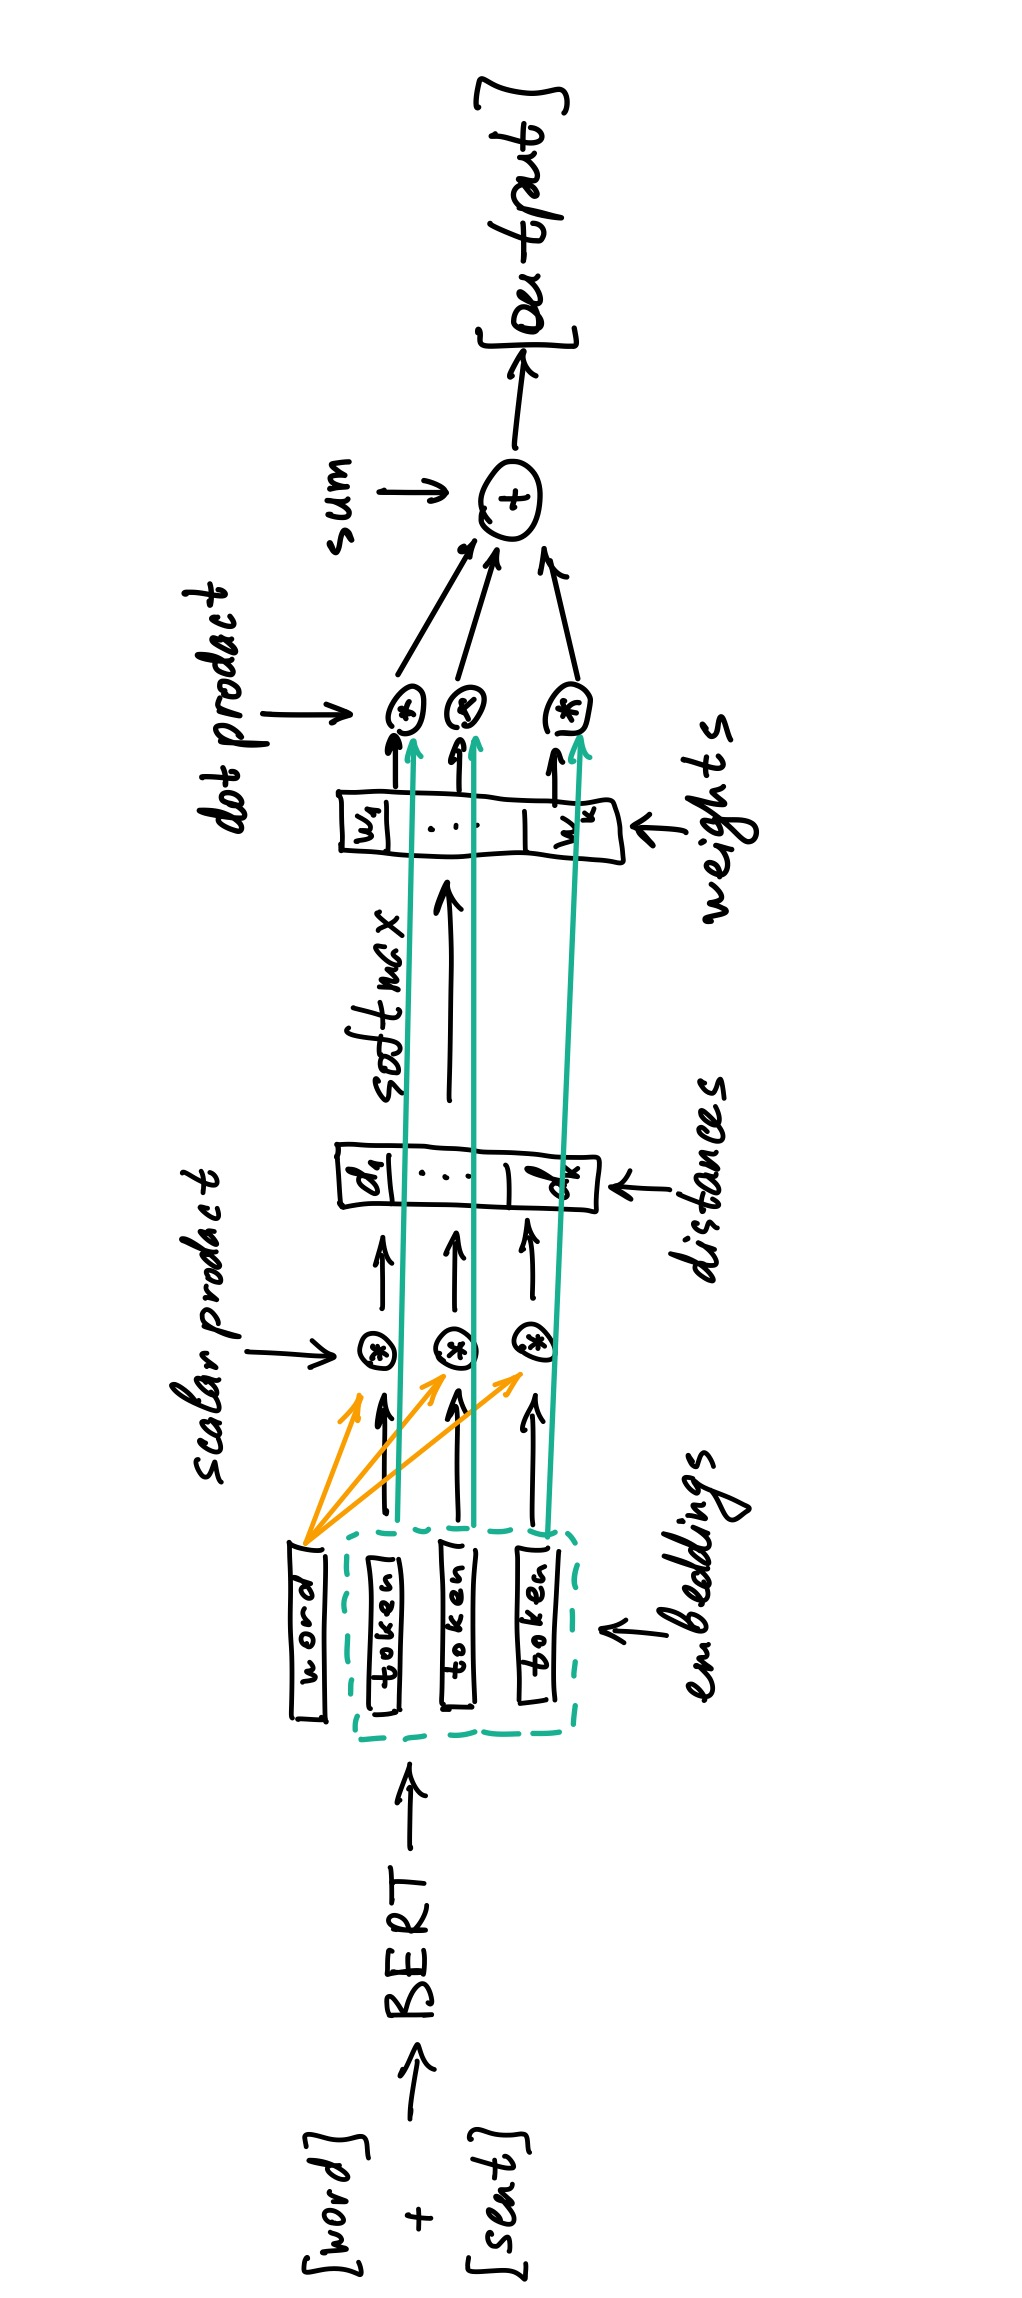

1. Word + sentence is input for BERT.
2. After BERT we have embeddings of all words.
3. Then we want model to know which words in the sentence is important for target word. So, we calculate the scalar prodact betweem target word and other words in the sentence and get the distances between them.
4. After that we do softmax and convert distances into weigths.
5. And finally we calculate weighted sum of all emdeddings of our sentence.
6. Use affinity propagation for clastarisation.

**NOTE:** 

1.   During model.eval() output is embedding.
2.   During model.train() output is Linear(768, num_classes).

**Parameters to be tuned:** 1 head, puller, classifier, embedder.

## 2.2 Discussion of results

## BTS

**Fine tuning**

1. Simple way: average of all embeddings in the sentence.


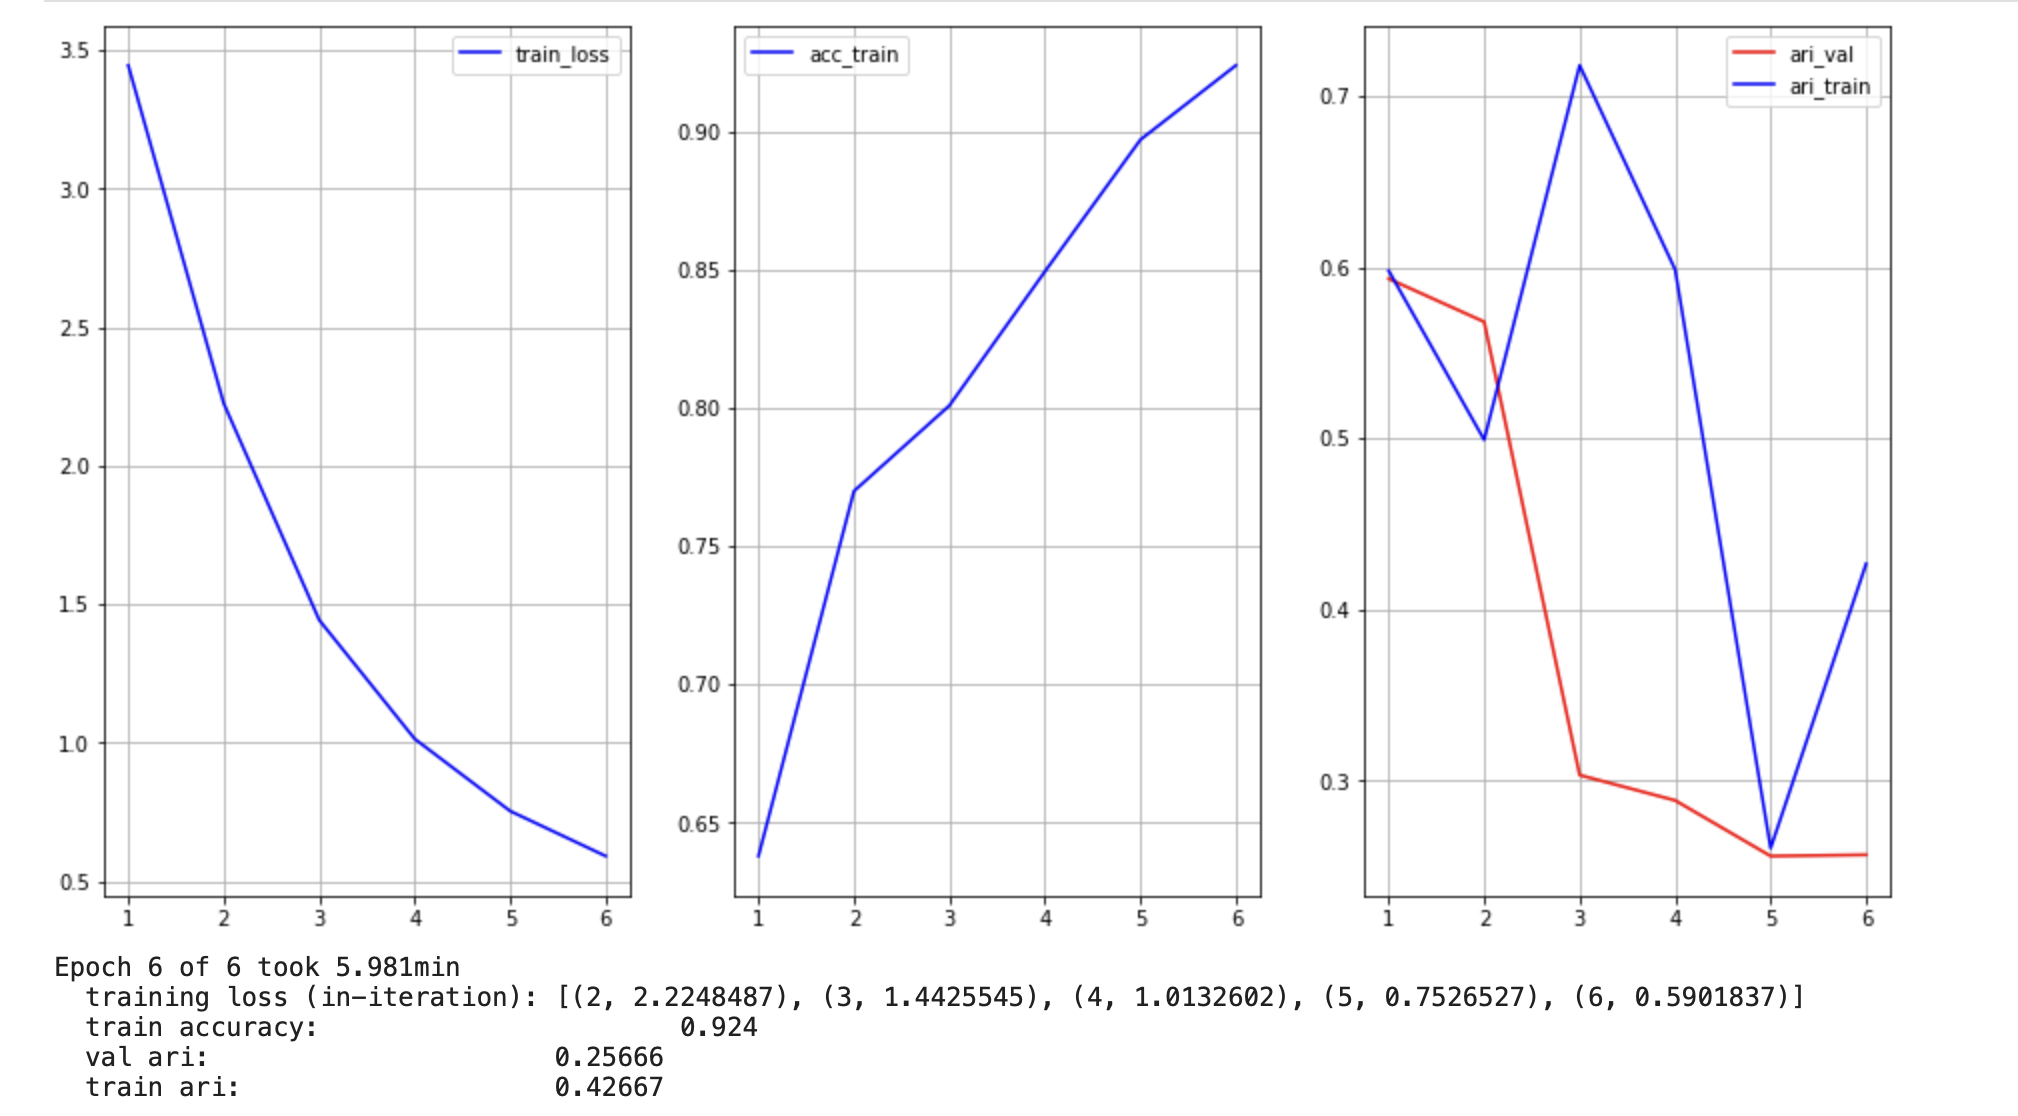

From these plots we can see that model is becoming overfitting despite that fact that score increase.

## Active dict

**Fine tuning**

1. Complicated way: just like on the picture in paragraph 2.

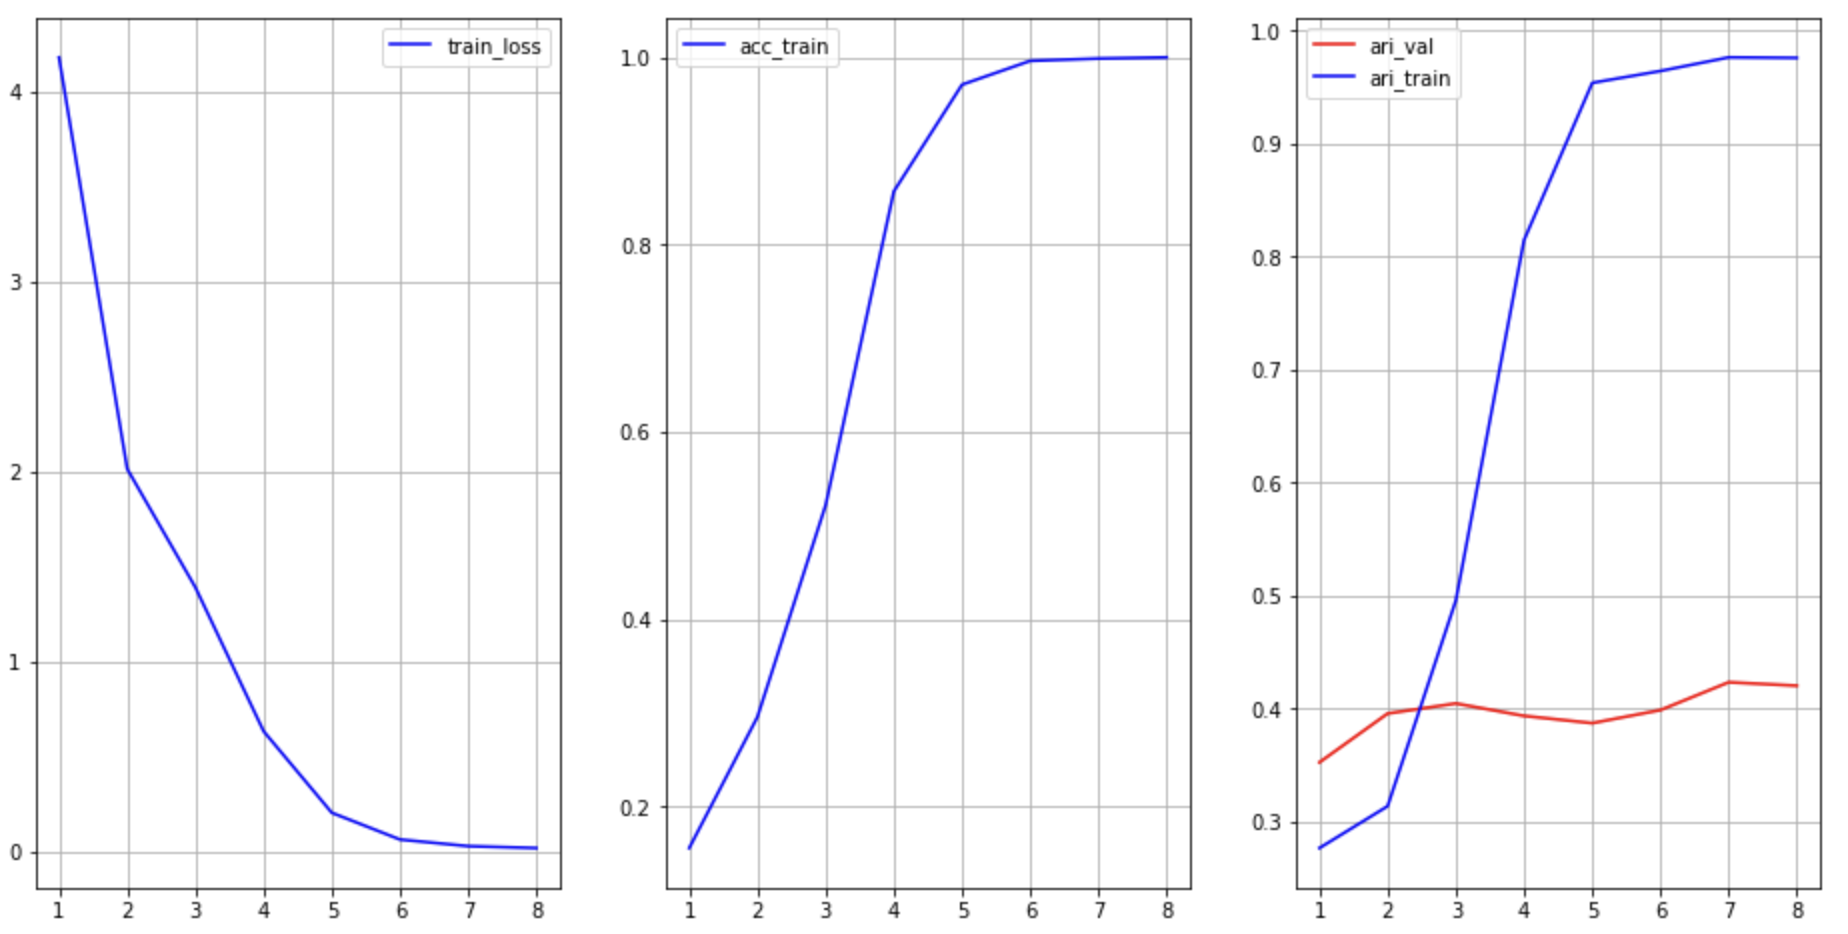

From these plots we can see that model is learning

***Enter here** a discussion of results and a summary of the experiment. Here we want to see the final table with comparison of the baseline and all tried approaches you decided to report. Even if some method did not bring you to the top of the leaderboard, you should nevertheless indicate this result and a discussion, why, in your opinion, some approach worked and another failed. Interesting findings in the discussion will be a plus.*

Method | Precision | Recall
--- | --- | ---
Baseline | 0.88 | 0.77
My great method 1 | 0.99 | 0.11
My great method 2 | 0.90 | 0.90

*If relevant insert plots and historgams in this section e.g. testing variation of the score with respect to some parameters e.g. learning rate or size of the input dataset, etc. Please do not use code to generate plots, instead just insert images as shown below. Plots could be generated from code in Section 3. *

![image](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d2/Sine_and_Cosine.svg/640px-Sine_and_Cosine.svg.png)

# 3. Code

*Enter here all code used to produce your results submitted to Codalab. Add some comments and subsections to navigate though your solution.*

*In this part you are expected to develop yourself a solution of the task and provide a reproducible code:*
- *Using Python 3;*
- *Contains code for installation of all dependencies;*
- *Contains code for downloading of all the datasets used*;
- *Contains the code for reproducing your results (in other words, if a tester downloads your notebook she should be able to run cell-by-cell the code and obtain your experimental results as described in the methodology section)*.


*As a result, you code will be graded according to these criteria:*
- ***Readability**: your code should be well-structured preferably with indicated parts of your approach (Preprocessing, Model training, Evaluation, etc.).*
- ***Reproducibility**: your code should be reproduced without any mistakes with “Run all” mode (obtaining experimental part).*


## 3.1 Requirements

In [ ]:
pip install spacy
# and some other your dependenciesb

Note: you may need to restart the kernel to use updated packages.


## 3.2 Download the data

In [ ]:
!wget http://panchenko.me/data/toxic/tagger-dstc8/dstc_conll_train.txt
# if some needed file is not in the public domain use google drive or other free hosting to make them available

--2021-11-28 14:05:22--  http://panchenko.me/data/toxic/tagger-dstc8/dstc_conll_train.txt
Resolving panchenko.me (panchenko.me)... 130.104.253.4
Connecting to panchenko.me (panchenko.me)|130.104.253.4|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29941431 (29M) [text/plain]
Saving to: ‘dstc_conll_train.txt’

dstc_conll_train.tx 100%[===================>]  28.55M  1.96MB/s    in 16s     

2021-11-28 14:05:38 (1.82 MB/s) - ‘dstc_conll_train.txt’ saved [29941431/29941431]



In [ ]:
!head -20 dstc_conll_train.txt

-DOCSTART- O
 
I O
'm O
looking O
for O
a O
place O
to O
eat O
. O
 
What O
are O
you O
in O
the O
mood O
for O
: O


## 3.3 Preprocessing 

In [ ]:
# Get some text from the input data

f = open("dstc_conll_train.txt")

tokens = []
for i, line in enumerate(f):
    if i > 200: break
    try:
        token, tag = line.split()
        tokens.append(token)
    except:
        continue
        
text = " ".join(tokens)  

print(text)

-DOCSTART- I 'm looking for a place to eat . What are you in the mood for : Mexican , Chinese , or something else ? Sushi sounds good right now . Which city do you want to eat in ? Somewhere affordable , that sells alcohol in SF . 2g Japanese Brasserie is a nice sushi restaurant in San Francisco . Can I call them ? Is there live music ? There is no live music , and their phone number is 415-292-9997 . Are there any other restauarnts nearby ? Akira Japanese Restaurant is also a sushi restaurant in San Francisco . That sounds good . Would you like to make a reservation ? Yes I would like to make a reservation . What time would you like the reservation ? Lets eat at five pm . Can you confirm the details : Booking a table for 2 people , at Akira Japanese Restaurant in San Francisco , today at 5 pm . Actually is is for six people . Okay. Can you confirm the details : Booking a table for


## 3.4 My method of text processing

In [ ]:
# Perform some processing of the text 

import spacy

nlp = spacy.load("en_core_web_sm")
doc = nlp(text)

# Analyze syntax
print("Noun phrases:", [chunk.text for chunk in doc.noun_chunks])
print("Verbs:", [token.lemma_ for token in doc if token.pos_ == "VERB"])

# Find named entities, phrases and concepts
for entity in doc.ents:
    print(entity.text, entity.label_)

Noun phrases: ['a place', 'What', 'you', 'the mood', 'Mexican', 'something', 'Sushi', 'you', 'alcohol', 'SF', 'g', 'Japanese Brasserie', 'a nice sushi restaurant', 'San Francisco', 'I', 'them', 'live music', 'no live music', 'their phone number', 'any other restauarnts', 'Akira Japanese Restaurant', 'a sushi restaurant', 'San Francisco', 'you', 'a reservation', 'I', 'a reservation', 'you', 'the reservation', 'Lets', 'five pm', 'you', 'the details', 'a table', '2 people', 'Akira Japanese Restaurant', 'San Francisco', '5 pm', 'six people', 'you', 'the details', 'a table']
Verbs: ['look', 'eat', 'sound', 'want', 'eat', 'sell', 'call', 'sound', 'like', 'make', 'like', 'make', 'like', 'eat', 'confirm', 'book', 'confirm', 'book']
Mexican NORP
Chinese NORP
SF GPE
2 CARDINAL
Japanese NORP
Brasserie PERSON
San Francisco GPE
415 CARDINAL
Japanese NORP
Restaurant PERSON
San Francisco GPE
five pm TIME
2 CARDINAL
Akira Japanese Restaurant ORG
San Francisco GPE
today DATE
5 pm TIME
six CARDINAL
